# If a picture is worth a thousand words, how many words are 8.35 GBs of pictures worth?

Cameras collect a dizzying array of facts everytime you snap a picture. For example, the date / time it was taken, the model of the camera used, the type of lens attached -- are all capture attributes. Smartphones will even store geolocation data! The data produced from a camera is collected in meta tags organized by the EXIF (Exchangeable image file) format. 

There are many insights we can uncover about a photographer by analyzing their EXIF data. We can make inferences about their skill level by identifying how many settings were set to 'auto'. We could classify photographers into different groups based on their lens preferences to suggest a lens to purchase.

In this analysis we will disect 8.35 GB worth of photos or nearly 5000 images I have taken. I will explain the three pillars of photography and visualize my preferences with respect to those three settings.

In [1]:
import exifread
import pandas as pd
import os
import numpy as np
import pylab as pl
import matplotlib.image as mpimg
%matplotlib inline

#all possible ISO values
ISO_vals = [50,64,80,100,125,160,200,250,320,400,500,640,800,1000,1250,
1600,2000,2500,3200,4000,5000,6400,8000,10000,12800,16000,
20000,25600,32000,40000]

#all possible f-stop values
f_stop_vals = [20.0,18.0,16.0,14.0,13.0,11.0,10.0,
               9.0,8.0,7.1,6.3,5.6,5.0,4.5,4.0,3.5,
               3.2,2.8,2.5,2.2,2.0,1.8,1.6,1.4,1.2]

#all possible shutter speed values
exposure_vals = ['1/8000','1/6400','1/5000','1/4000','1/3200','1/2500','1/2000','1/1600','1/1250','1/1000',
                 '1/800','1/640','1/500','1/400','1/320','1/250','1/200','1/160','1/125','1/100','1/80',
                 '1/60','1/50','1/40','1/30','1/25','1/20','1/15','1/13','1/10']

#define function to prepare camera settings for plot
def map_camera_vals(image_id,df):
    
    #select the image from the dataframe
    image_row = df[df['image_name']==image_id]

    #set the values
    ISO_in = image_row['ISO'][0]

    f_stop_in = image_row['f_stop_adj'][0]

    exposure_in = image_row['exposure_adj'][0]

    #convert ISO val to normalized chart value
    ISO_num = (ISO_vals.index(ISO_in)/(len(ISO_vals)-1))*5

    #convert f stop val to normalized chart value
    f_stop_num = (f_stop_vals.index(f_stop_in)/(len(f_stop_vals)-1))*5

    #convert exposure val to normalized chart value
    exposure_num = (exposure_vals.index(exposure_in)/(len(exposure_vals)-1))*5
    
    return [ISO_num,f_stop_num,exposure_num]

#define function that will build the radar chart
class Radar(object):

    def __init__(self, fig, titles, labels,rect=None):
        if rect is None:
            rect = [0.05, 0.05, 0.95, 0.95]

        self.n = len(titles)
        self.angles = np.arange(90, 90+360, 360.0/self.n)
        self.axes = [fig.add_axes(rect, projection="polar", label="axes%d" % i) 
                         for i in range(self.n)]

        self.ax = self.axes[0]
        self.ax.set_thetagrids(self.angles, labels=titles, fontsize=14)

        for ax in self.axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)

        for ax, angle, label in zip(self.axes, self.angles, labels):
            ax.set_rgrids(range(1, 6), angle=angle, labels=label)
            ax.spines["polar"].set_visible(False)
            ax.set_ylim(0, 5)

    def plot(self, values, *args, **kw):
        angle = np.deg2rad(np.r_[self.angles, self.angles[0]])
        values = np.r_[values, values[0]]
        self.ax.plot(angle, values, *args, **kw)

#directory where images are stored
pic_direc = os.listdir('images_sample')

print("Number of images in directory: "+ str(len(pic_direc)))

Number of images in directory: 9


# Read in data

Using the exifread package, we read in each image and create a dataframe populated with the meta tags available.

In [8]:
#get all tags
f = open('images_sample//' + pic_direc[0], 'rb')

tags = exifread.process_file(f)

#create empty dataframe with exif tags as headers
exif_df = pd.DataFrame(columns=tags.keys())

for pic in pic_direc:
    
    #open image
    f = open('images_sample//' + pic, 'rb')

    tags = exifread.process_file(f)
    
    #create row of data with tag values
    exif_df_small = pd.DataFrame(tags, index=[0])
    
    #append to dataframe
    exif_df = exif_df.append(exif_df_small)
    
exif_df['image_name'] = pic_direc

# Basic EXIF tags

Since we will be anlayzing several concepts that are particular to photography, I want to set some context on what these three measurements are. For this anlaysis we are going to look at the role light plays in capturing a good photo. Too much light, and your image will be whiteout. Too little light and your image will be a black screen. To account for differently lit environments can use three levers:

## ISO

"The measure of a photographic film's sensitivity to light". Although digital cameras dont use film, we can think of the camera's sensor as the film. This lever will make the sensor either more senstive to light (High ISO setting, used when dark) or less sensitive to light (Low ISO setting, used when bright outside)

Range:

50-409600

## F-Stop

"The ratio of the system's focal length to the diameter of the entrance pupil". In other words, it is a measure of the size of the hole that lets the light in. A low f-stop signifies a larger opening and is used in low light situations. A high f-stop signifies smaller opening and is used in bright light situations.

Range:

1.2-16

## Exposure Time

"The length of time when the film or digital sensor inside the camera is exposed to light". Longer exposure time is used in lower light situations and a shorter exposure time is used in bright light situations.

Range:

1/8000 - 30 (seconds)



The relative balance of the three meausures will produce different aesthetic properties, but they must be juggled in order to take a proper picture. How they are balanced and which measures are set to "auto" could be quantitative measures of how we define "photographic style" or group photographers together.

# Select relevant columns for analysis

One day we will sift through all those exif tags...but that day is not today.

In [9]:
exif_df_sel = exif_df.loc[:,['image_name',
                         'EXIF ExposureTime',
                         'EXIF ISOSpeedRatings',
                         'EXIF FNumber',
                            ]]

#unselect ghost file
exif_df_sel = exif_df_sel.iloc[1:,:]

#convert to strings
exif_df_sel = exif_df_sel.astype(str)

exif_df_sel.head(10)

,image_name,EXIF ExposureTime,EXIF ISOSpeedRatings,EXIF FNumber
0,DSC00092.jpg,1/20,6400,2
0,DSC00491.jpg,1/1600,50,16/5
0,DSC03064.jpg,1/320,160,8
0,DSC03112.jpg,1/15,200,14/5
0,DSC03253.jpg,1/4,640,2
0,DSC03384.jpg,1/400,100,14/5
0,IMG_0925.jpg,1/200,100,9
0,IMG_1968.jpg,1/60,100,22


## Clean up Variables

Fields come in different forms from the two cameras

convert exposure to a float



In [10]:
#convert to fraction

exif_df_sel['EXIF ExposureTime_num'] = exif_df_sel['EXIF ExposureTime'].str.split(pat='/',expand=True)[0].astype(int)

exif_df_sel['EXIF ExposureTime_denom'] = exif_df_sel['EXIF ExposureTime'].str.split(pat='/',expand=True)[1]

exif_df_sel['EXIF ExposureTime_denom'] = exif_df_sel['EXIF ExposureTime_denom'].fillna(1).astype(int)

exif_df_sel['exposure_time'] = exif_df_sel['EXIF ExposureTime_num'] / exif_df_sel['EXIF ExposureTime_denom']

#convert to float

exif_df_sel['EXIF FNumber_num'] = exif_df_sel['EXIF FNumber'].str.split(pat='/',expand=True)[0].astype(int)

exif_df_sel['EXIF FNumber_denom'] = exif_df_sel['EXIF FNumber'].str.split(pat='/',expand=True)[1]

exif_df_sel['EXIF FNumber_denom'] = exif_df_sel['EXIF FNumber_denom'].fillna(1).astype(int)

#convert other fields to integers

exif_df_sel['f_stop'] = exif_df_sel['EXIF FNumber_num'] / exif_df_sel['EXIF FNumber_denom']

exif_df_sel['ISO'] = exif_df_sel['EXIF ISOSpeedRatings'].astype(int)

#select the relavent columns

exif_df_clean = exif_df_sel.loc[:,['image_name',
                                 'exposure_time',
                                 'EXIF ExposureTime',
                                 'f_stop',
                                 'ISO',
                                 ]]

exif_df_clean.head(10)

,image_name,exposure_time,EXIF ExposureTime,f_stop,ISO
0,DSC00092.jpg,0.050000,1/20,2.0,6400
0,DSC00491.jpg,0.000625,1/1600,3.2,50
0,DSC03064.jpg,0.003125,1/320,8.0,160
0,DSC03112.jpg,0.066667,1/15,2.8,200
0,DSC03253.jpg,0.250000,1/4,2.0,640
0,DSC03384.jpg,0.002500,1/400,2.8,100
0,IMG_0925.jpg,0.005000,1/200,9.0,100
0,IMG_1968.jpg,0.016667,1/60,22.0,100


# Plot 100 random photos

In order to analyze the relationship between these 3 measures, I want to plot them on a radar chart. Around the edges of the radar chart, each measure has its lowest light setting. At the center of the radar chart each measure has its highest light setting.

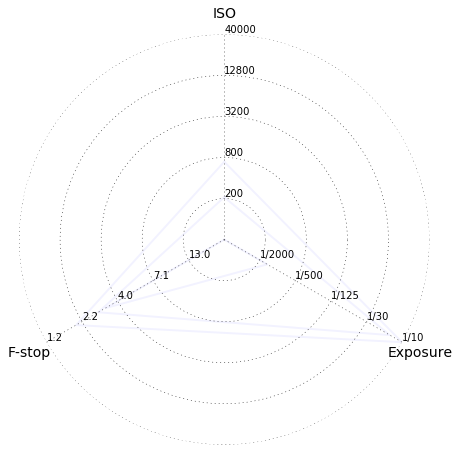

In [11]:
#set long-exposure shots to 1/10 seconds
exif_df_clean['exposure_adj'] = np.where(exif_df_clean['exposure_time']>=.1,'1/10',exif_df_clean['EXIF ExposureTime'])

#set f-stop vals above 20 to 20
exif_df_clean['f_stop_adj'] = np.where(exif_df_clean['f_stop']>20,20,exif_df_clean['f_stop'])

exif_small = exif_df_clean.sample(frac=.4).head(300)

fig = pl.figure(figsize=(6, 6))

#titles for plot
titles = ['ISO','F-stop','Exposure']

#labels for tick marks
labels = [[200,800,3200,12800,40000],
         [13.0,7.1,4.0,2.2,1.2],
         ['1/2000','1/500','1/125','1/30','1/10']]

#initialize radar chart
radar = Radar(fig, titles,labels)

#loop through all photos in the dataframe
for i in exif_small['image_name'].tolist():
    
    image = i
    cam_vals = map_camera_vals(image_id=image,df=exif_small)

    radar.plot(cam_vals,  "-", lw=2, color="b", alpha=0.05,label='1')

# How does brightness play a role in the camera's settings?

Although the end result of a good picture is always lit enough for us to see, many adjustments have to be made to the camera. We will see the drastic difference in settings of pictures taken at night vs pictures taken during the day.

To start, I have picked a picture that has a pretty neutral light setting. It was the middle of the day, but slightly overcast (A brief afternoon sun shower).

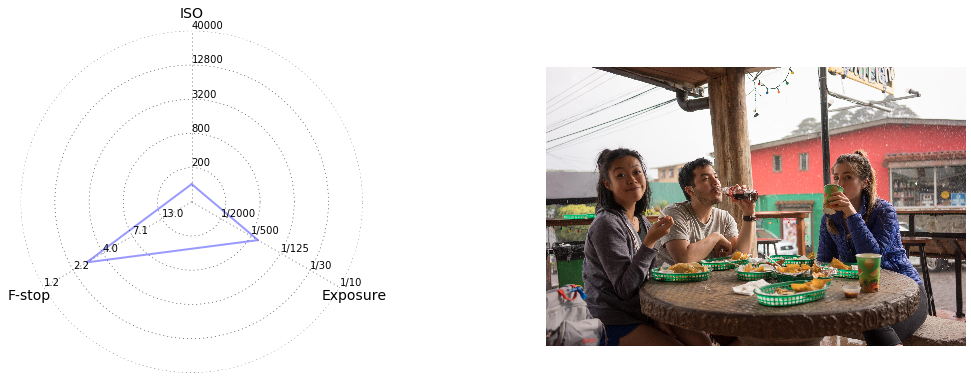

In [12]:
image = 'DSC03384.jpg'
cam_vals = map_camera_vals(image_id=image,df=exif_df_clean)

#plot the radar
fig = pl.figure(figsize=(30,5))
radar = Radar(fig, titles,labels)
radar.plot(cam_vals,  "-", lw=2, color="b", alpha=0.4,label='1')

#add the subplot for the image
fig.add_subplot(1,3,3)
pl.axis("off")

#read in the image
img=mpimg.imread('IMAGE_STUDY//'+image)

#show the image
imgplot=pl.imshow(img)
pl.show()

# Dark Photos

Many of these images were taken at night when there was little natural light available. The area of the triangle is much larger to account for the low light.

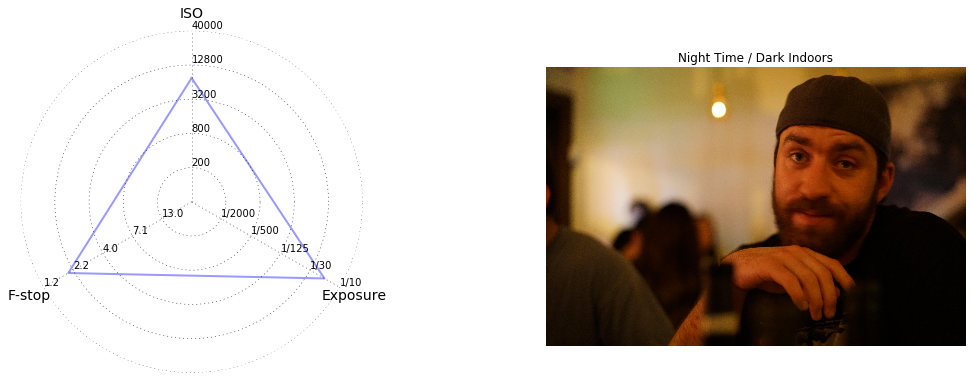

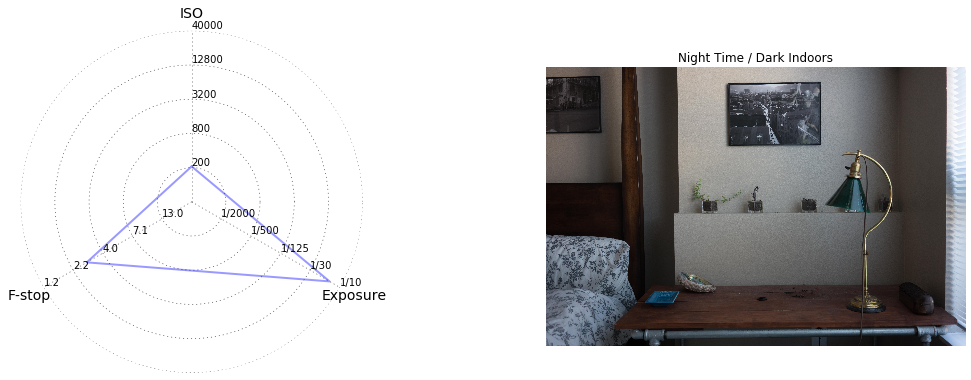

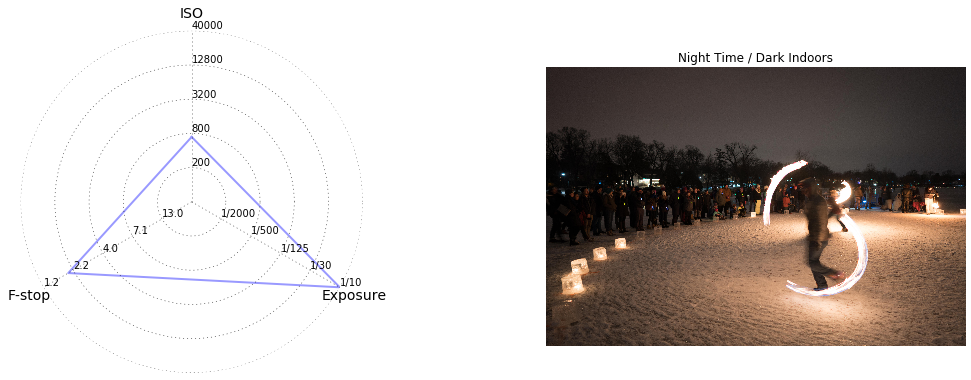

In [13]:
dark_photos = 'DSC00092.jpg','DSC03112.jpg','DSC03253.jpg'

for i in dark_photos:
    image = i
    cam_vals = map_camera_vals(image_id=image,df=exif_df_clean)

    #plot the radar
    fig = pl.figure(figsize=(30,5))
    radar = Radar(fig, titles,labels)
    radar.plot(cam_vals,  "-", lw=2, color="b", alpha=0.4,label='1')

    #add the subplot for the image
    fig.add_subplot(1,3,3)
    pl.axis("off")

    #read in the image
    img=mpimg.imread('IMAGE_STUDY//'+image)

    #show the image
    imgplot=pl.imshow(img)
    pl.title('Night Time / Dark Indoors')
    pl.show()

# Light Photos

Many of these images were taken during the day when there was plenty of natural light available. The area of the triangle is much smaller to account for the bright light.

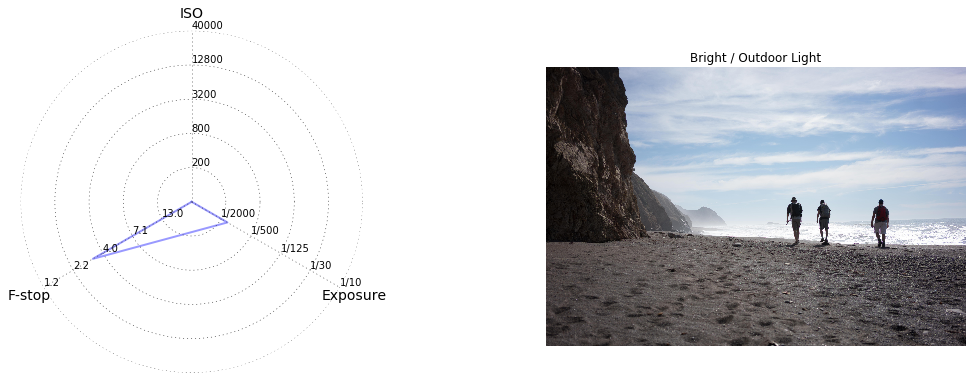

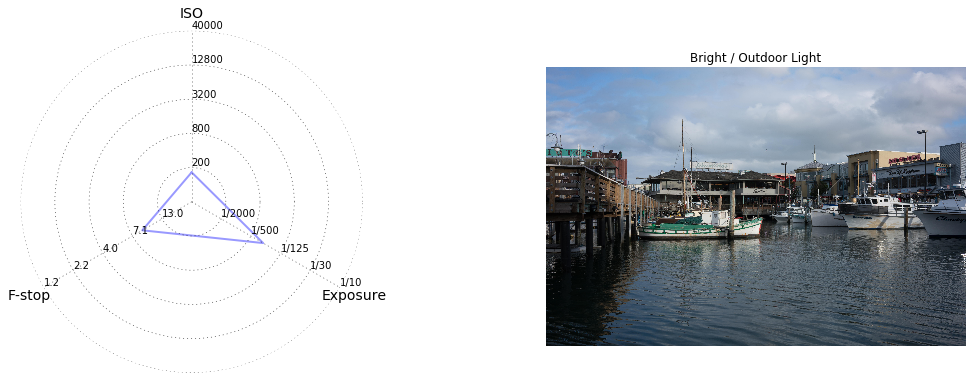

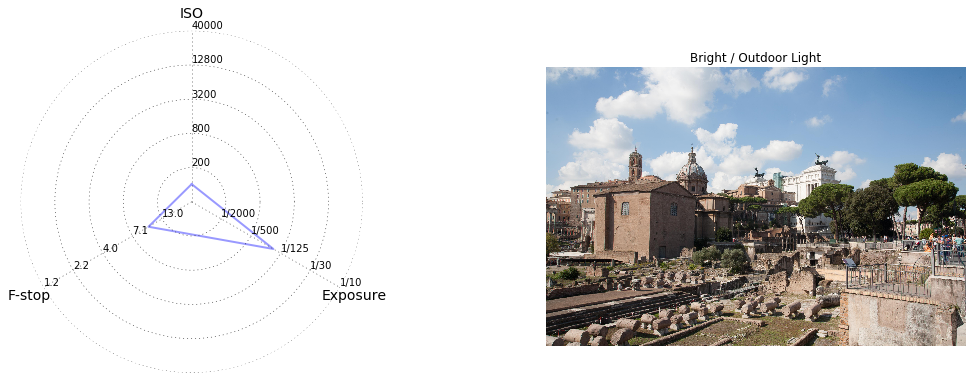

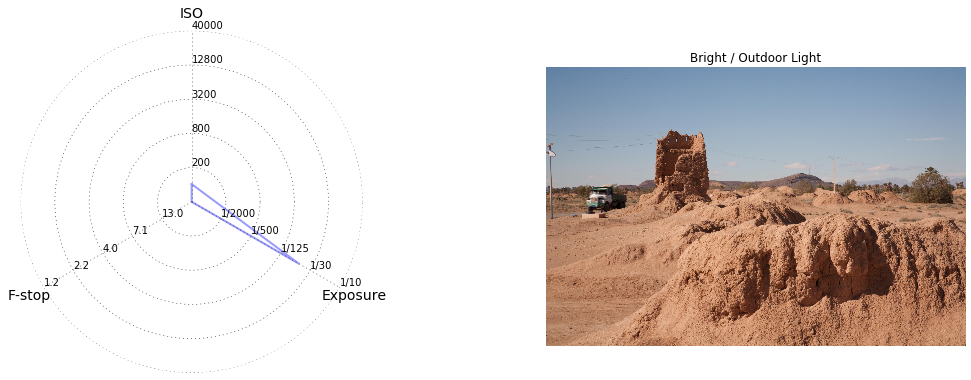

In [14]:
light_photos ='DSC00491.jpg','DSC03064.jpg','IMG_0925.jpg','IMG_1968.jpg'

for i in light_photos:
    image = i
    cam_vals = map_camera_vals(image_id=image,df=exif_df_clean)

    #plot the radar
    fig = pl.figure(figsize=(30,5))
    radar = Radar(fig, titles,labels)
    radar.plot(cam_vals,  "-", lw=2, color="b", alpha=0.4,label='1')

    #add the subplot for the image
    fig.add_subplot(1,3,3)
    pl.axis("off")

    #read in the image
    img=mpimg.imread('IMAGE_STUDY//'+image)

    #show the image
    imgplot=pl.imshow(img)
    pl.title('Bright / Outdoor Light')
    pl.show()

# Next Steps

Given that this analysis was exploratory in nature, it brought up many more questions than it ended up answering. It has given me some ideas for next steps that I would like to explore:

1) Design an algorithm to classify if the photo was taken indoors / outdoors photos based on these 3 measures

2) Explore other exif tags like focal length or auto settings

3) Build a clustering algorithm to understand my most common shooting styles

4) Compare shooting styles to other photographers

5) See how my shooting style has evolved over the years


If you have any ideas or improvements on this script please reach out to me at matthew.terzolo@colorado.edu. Thanks for reading!